Machine Learning HW3 , ChunTing Kuo

In [146]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


1. Gaussian Process for Regression (40%)

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [148]:
X = pd.read_csv("/content/gdrive/MyDrive/Colab/dataset/gp_x.csv",header=None).squeeze()
T = pd.read_csv("/content/gdrive/MyDrive/Colab/dataset/gp_t.csv",header=None).squeeze()
train_x = X[:50]
test_x = X[50:]
train_t = T[:50]
test_t = T[50:]
train_x = np.array(train_x)
test_x = np.array(test_x)
train_t = np.array(train_t)
test_t = np.array(test_t)
print(X.shape)
print(T.shape)
print(train_x.shape)
print(test_x.shape)
print(train_t.shape)
print(train_t.shape)

(100,)
(100,)
(50,)
(50,)
(50,)
(50,)


In [149]:
# set param
kernel = [[0, 0, 0, 1], 
      [1, 16, 0, 0], 
      [1, 16, 0, 4], 
      [1, 64, 32, 0]]
x = np.linspace(0, 2, 300)
y = np.empty(300)
y1 = np.empty(300)
y2 = np.empty(300)

In [150]:
def RootMeanSqureError(predict, train_y):
  return np.sqrt(np.sum((predict-train_y)**2)/len(predict))

def print_table(t1, t2, t3):
  return pd.DataFrame(columns=[t1, t2, t3])

table = print_table("parameters", "training error", "testing error")

1-1. Please implement the Gaussian Process with exponential-quadratic kernel function

1-2. Plot the prediction result like Figure 6.8 of textbook for training set but one standard deviation

1-3. Show the corresponding root-mean-square errors

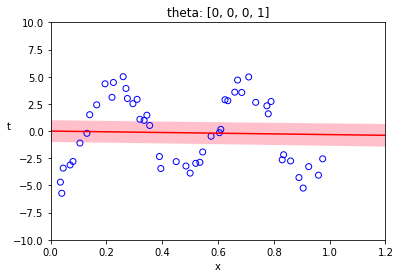

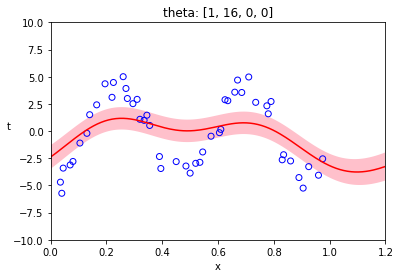

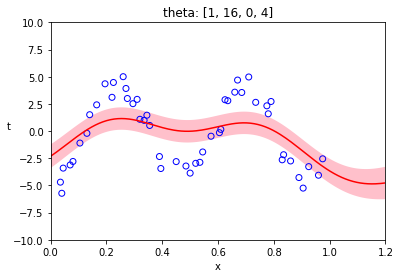

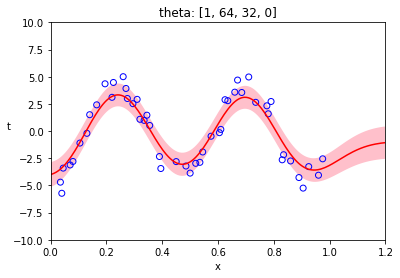

     parameters  training error  testing error
   (0, 0, 0, 1)        3.129201       3.344399
  (1, 16, 0, 0)        2.423928       2.668052
  (1, 16, 0, 4)        2.410576       2.656998
 (1, 64, 32, 0)        1.042886       1.162759


In [151]:
beta_inv = 1
def exponential_quadratic_kernel(x, y, kernel):
  a = np.exp(-0.5*kernel[1]*np.subtract.outer(x, y)**2)
  b = np.multiply.outer(x, y)
  return kernel[0]*a + kernel[2] + kernel[3]*b

def gaussian_process(table, kernel, C_inv, p):
  beta_inv = 1
  for i in range(300):
    k = exponential_quadratic_kernel(train_x, x[i], kernel[p])
    c_matrix = exponential_quadratic_kernel(x[i], x[i], kernel[p]) + beta_inv
    std = np.sqrt(c_matrix - np.linalg.multi_dot([k.T, C_inv, k]))
    y[i] = np.linalg.multi_dot([k, C_inv, train_t])  # mean
    y1[i] = y[i] + std
    y2[i] = y[i] - std
  plot_gaussian_process(y1, y2, kernel[p])
  # calculate the rms on training and test data
  train_y = np.empty(50)
  for i in range(50):
    k = exponential_quadratic_kernel(train_x, train_x[i], kernel[p])
    train_y[i] = np.linalg.multi_dot([k, C_inv, train_t])
      
  predict = np.empty(50)
  for i in range(50):
    k = exponential_quadratic_kernel(train_x, test_x[i], kernel[p])
    predict[i] = np.linalg.multi_dot([k, C_inv, train_t])
  return table.append(pd.Series(["("+str(kernel[p])[1:-1]+")", RootMeanSqureError(train_y, train_t), RootMeanSqureError(predict, test_t)], index=["parameters", "training error", "testing error"]), ignore_index=True)

def plot_gaussian_process(y1, y2, title, save=1):
    plt.plot(x, y, 'r-')
    plt.fill_between(x, y1, y2, facecolor='pink', edgecolor='none')
    plt.scatter(train_x, train_t, facecolors='none', edgecolors='b')  # plot the data point
    plt.title("theta: "+str(title))
    plt.xlim(0, 1.2)
    plt.ylim(-10, 10)
    plt.xlabel('x')
    plt.ylabel('t', rotation=0)
    #plt.savefig('/content/gdrive/MyDrive/Colab/MLhw3/'+ str(p) + '.png')
    plt.show()

# iterate throw 4 set of paramaters
for p in range(4):
  C_inv = np.linalg.inv(exponential_quadratic_kernel(train_x, train_x, kernel[p]) + beta_inv * np.identity(50))
  table = gaussian_process(table, kernel, C_inv, p)
print(table.to_string(index=False))

1-4. Try to tune the hyperparameters by trial and error or use automatic relevance determination (ARD) in Chapter 6.4.4 of textbook

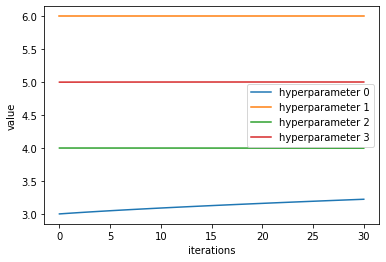

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


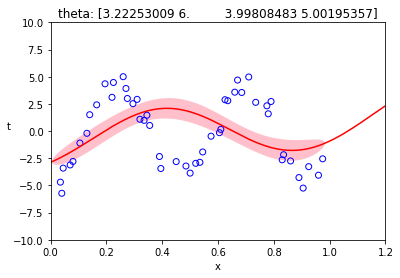

                                    parameters  training error  testing error
 (3.22253009 6.         3.99808483 5.00195357)        3.101112       3.565482


In [152]:
ARD_parameters = [[3, 6, 4, 5]]
update = [0, 0, 0, 0]
learning_rate = 0.001
beta_inv = -1

# tune hyperparameters with ARD
def log_likelihood(C_inv, C_matrix, t):
    return -0.5 * np.trace(C_inv.dot(C_matrix)) + 0.5 * np.linalg.multi_dot([t.T, C_inv, C_matrix, C_inv, t])


def ARD(para): #automatic relevance determination
  while True:
    C_inv = np.linalg.inv(exponential_quadratic_kernel(train_x, train_x, para[-1]) + beta_inv * np.identity(50))
    # update parameter
    update[0] = log_likelihood(C_inv, np.exp(-0.5 * para[-1][1] * np.subtract.outer(train_x, train_x)**2), train_t)
    update[1] = log_likelihood(C_inv, para[-1][0] * -0.5 * np.subtract.outer(train_x, train_x) * np.exp(-0.5 * para[-1][1] * np.subtract.outer(train_x, train_x)**2), train_t)
    update[2] = log_likelihood(C_inv, np.full([50, 50], 1), train_t)
    update[3] = log_likelihood(C_inv, np.multiply.outer(train_x, train_x), train_t)
    para.append([p + learning_rate * dev for p, dev in zip(para[-1], update)])
    if np.max(np.abs(update)) < 6:
      break;
  
  para = np.array(para)
  #print(para)
  plt.plot(para[:, 0], label='hyperparameter 0')
  plt.plot(para[:, 1], label='hyperparameter 1')
  plt.plot(para[:, 2], label='hyperparameter 2')
  plt.plot(para[:, 3], label='hyperparameter 3')
  plt.legend()
  plt.xlabel("iterations")
  plt.ylabel("value", rotation=90)
  plt.show()

  return para



ARD_parameters = ARD(ARD_parameters)
ARD_table = print_table("parameters", "training error", "testing error")
ARD_C_inv = np.linalg.inv(exponential_quadratic_kernel(train_x, train_x, ARD_parameters[-1]) + beta_inv * np.identity(50))
ARD_table = gaussian_process(ARD_table, ARD_parameters, ARD_C_inv,-1)
print(ARD_table.to_string(index=False))

2. Support Vector Machine (40%)

In [153]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [154]:
train_input = pd.read_csv('/content/gdrive/MyDrive/Colab/dataset/x_train.csv', header=None)
train_target = pd.read_csv('/content/gdrive/MyDrive/Colab/dataset/t_train.csv', header=None).iloc[:, 0].values
X = np.array(train_input)
y = np.array(train_target)
print(X.shape)
print(y.shape)

(300, 784)
(300,)


In [155]:
classes = [(0, 1), (0, 2), (1, 2)]
def SVD(u, v, u_based_decision=True):
  #https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py#L500
  if u_based_decision:
      # columns of u, rows of v
      max_abs_cols = np.argmax(np.abs(u), axis=0)
      signs = np.sign(u[max_abs_cols, range(u.shape[1])])
      u *= signs
      v *= signs[:, np.newaxis]
  else:
      # rows of v, columns of u
      max_abs_rows = np.argmax(np.abs(v), axis=1)
      signs = np.sign(v[range(v.shape[0]), max_abs_rows])
      u *= signs
      v *= signs[:, np.newaxis]
  return u, v
def PCA(features):
  n=2
  M = np.mean(features.T, axis=1)
  C = features - M
  u, d, v = np.linalg.svd(C, full_matrices=False)
  u, v = SVD(u, v)
  Trans_comp = np.dot(features.T, u[:, :n])
  s = np.diag(d)
  Trans = u[:, :n].dot(s[:n, :n])
  return Trans, Trans_comp.T

print(X.shape)

(300, 784)


2-1 Linear Kernel SVM

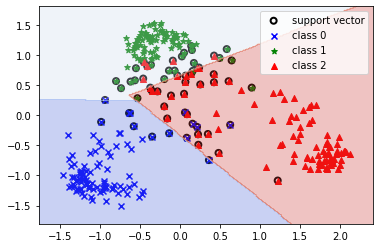

In [156]:
def update(a, t, x):
  at = a * t
  w = at.dot(x)
  M_indexes = np.where(((a > 0) & (a < 1)))[0]
  S_indexes = np.nonzero(a)[0]
  if len(M_indexes) == 0:
    b = -1
  else:
    b = np.mean(t[M_indexes] - at[S_indexes].dot(np.dot(x[M_indexes], x[S_indexes].T).T))
  return w, b

def train_LinearSVM(X, labels, support_vectors, coef):
  size = 100
  target_dict = {}
  target_dict[(0, 1)] = np.concatenate((np.ones(size), np.full([size], -1), np.zeros(size)))
  target_dict[(0, 2)] = np.concatenate((np.ones(size), np.zeros(size), np.full([size], -1)))
  target_dict[(1, 2)] = np.concatenate((np.zeros(size), np.ones(size), np.full([size], -1)))

  multiplier = np.zeros([len(X), 2])
  multiplier[support_vectors] = coef.T
  multiplier_dict = {}
  multiplier_dict[(0, 1)] = np.concatenate((multiplier[:size * 2, 0], np.zeros(size)))
  multiplier_dict[(0, 2)] = np.concatenate((multiplier[:size, 1], np.zeros(size), multiplier[size * 2:, 0]))
  multiplier_dict[(1, 2)] = np.concatenate((np.zeros(size), multiplier[size:, 1]))
  
  weights = {}
  biases = {}
  for c1, c2 in labels:
    weight, bias = update(multiplier_dict[(c1, c2)], target_dict[(c1, c2)], X)
    weights[(c1, c2)] = weight
    biases[(c1, c2)] = bias
  return weights, biases

def prediction(X, label, weights, biases):
  predictions = []
  for index in range(len(X)):
    count = []
    for c1, c2 in label:
      weight = weights[(c1, c2)]
      bias = biases[(c1, c2)]
      y = weight.dot(X[index].T) + bias
      if y > 0:
        count += [c1]
      else:
        count += [c2]
    predictions += [Counter(count).most_common()[0][0]]
  return predictions

def meshgrid(x, y):
  space = 0.3
  h=0.02
  x_min, x_max = x.min() - space, x.max() + space
  y_min, y_max = y.min() - space, y.max() + space
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
  return xx, yy

def plot(support_vectors, X, t, xx, yy, prediction):
    class0_indexes = np.where(t == 0)
    class1_indexes = np.where(t == 1)
    class2_indexes = np.where(t == 2)
    plt.scatter(X[support_vectors, 0], X[support_vectors, 1], facecolors='none', edgecolors='k', linewidths=2, label="support vector")
    plt.scatter(X[class0_indexes][:, 0], X[class0_indexes][:, 1], c='b', marker='x', label="class 0")
    plt.scatter(X[class1_indexes][:, 0], X[class1_indexes][:, 1], c='g', marker='*', label="class 1")
    plt.scatter(X[class2_indexes][:, 0], X[class2_indexes][:, 1], c='r', marker='^', label="class 2")
    plt.legend()
    plt.contourf(xx, yy, prediction, alpha=0.3, cmap=plt.cm.coolwarm)

X = np.array(train_input)
y = np.array(train_target)
X, svd = PCA(X)
X = (X - X.mean()) / X.std()

clf = SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X,y)
w, b = train_LinearSVM(X, classes, clf.support_, np.abs(clf.dual_coef_))
xx, yy = meshgrid(X[:, 0], X[:, 1])
predictions = prediction(np.column_stack((xx.flatten(), yy.flatten())), classes, w, b)
plot(clf.support_, X, y, xx, yy, np.array(predictions).reshape(xx.shape))
# plt.savefig('./images/svm_ovo_linearKernel.png')
plt.show()

2-2 Polynomial (homogeneous) kernel of degree 2, SVM

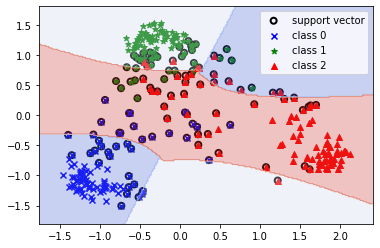

In [157]:
def poly_phi(x):
  if len(x.shape) == 1:
    return np.vstack((x[0] ** 2, np.sqrt(2) * x[0] * x[1], x[1] ** 2)).T
  else:
    return np.vstack((x[:, 0] ** 2, np.sqrt(2) * x[:, 0] * x[:, 1], x[:, 1] ** 2)).T

def poly_update(a, t, x):
  at = a * t
  if len(x.shape) == 1:
    num = np.vstack((x[0] ** 2, np.sqrt(2) * x[0] * x[1], x[1] ** 2)).T
  else:
    num = np.vstack((x[:, 0] ** 2, np.sqrt(2) * x[:, 0] * x[:, 1], x[:, 1] ** 2)).T
  w = at.dot(num)
  M_indexes = np.where(((a > 0) & (a < 1)))[0]
  S_indexes = np.nonzero(a)[0]
  if len(M_indexes) == 0:
    b = -1
  else:
    b = np.mean(t[M_indexes] - at[S_indexes].dot(np.dot(poly_phi(x[M_indexes]), poly_phi(x[S_indexes]).T).T))
  return w, b

def train_PolySVM(X, labels, support_vectors, coef):
  size = 100
  target_dict = {}
  target_dict[(0, 1)] = np.concatenate((np.ones(size), np.full([size], -1), np.zeros(size)))
  target_dict[(0, 2)] = np.concatenate((np.ones(size), np.zeros(size), np.full([size], -1)))
  target_dict[(1, 2)] = np.concatenate((np.zeros(size), np.ones(size), np.full([size], -1)))

  multiplier = np.zeros([len(X), 2])
  multiplier[support_vectors] = coef.T
  multiplier_dict = {}
  multiplier_dict[(0, 1)] = np.concatenate((multiplier[:size * 2, 0], np.zeros(size)))
  multiplier_dict[(0, 2)] = np.concatenate((multiplier[:size, 1], np.zeros(size), multiplier[size * 2:, 0]))
  multiplier_dict[(1, 2)] = np.concatenate((np.zeros(size), multiplier[size:, 1]))
  
  weights = {}
  biases = {}
  for c1, c2 in labels:
    weight, bias = poly_update(multiplier_dict[(c1, c2)], target_dict[(c1, c2)], X)
    weights[(c1, c2)] = weight
    biases[(c1, c2)] = bias
  return weights, biases


def prediction(X, label, weights, biases):
  predictions = []
  for index in range(len(X)):
    count = []
    for c1, c2 in label:
      weight = weights[(c1, c2)]
      bias = biases[(c1, c2)]
      y = weight.dot(poly_phi(X[index]).T) + bias
      if y > 0:
        count += [c1]
      else:
        count += [c2]
    predictions += [Counter(count).most_common()[0][0]]
  return predictions


X = np.array(train_input)
y = np.array(train_target)
X, svd = PCA(X)
X = (X - X.mean()) / X.std()

# 2. polynomial kernel
clf_poly = SVC(kernel='poly', C=1, degree=2, decision_function_shape='ovo').fit(X,y)
w_poly, b_poly = train_PolySVM(X, classes, clf_poly.support_, np.abs(clf_poly.dual_coef_))
xx, yy = meshgrid(X[:, 0], X[:, 1])
predictions_poly = prediction(np.column_stack((xx.flatten(), yy.flatten())), classes, w_poly, b_poly)
plot(clf_poly.support_, X, y, xx, yy, np.array(predictions_poly).reshape(xx.shape))
# plt.savefig('./images/svm_ovo_polyKernel.png')
plt.show()

3. Gaussian Mixture Model (30%)

3-1 Please build a K-means model by minimizing J function

3-2 Plot the log likelihood curve of GMM.

3-3 Show the resulting images for K = 3, 5, 7, and 10

======= K = 3 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    |  49 |  45 |  33 |
|    1    | 183 | 159 | 113 |
|    2    | 178 | 207 | 223 |
+---------+-----+-----+-----+



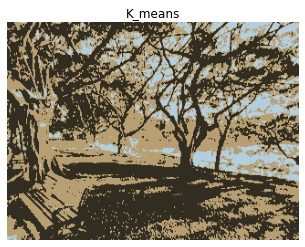

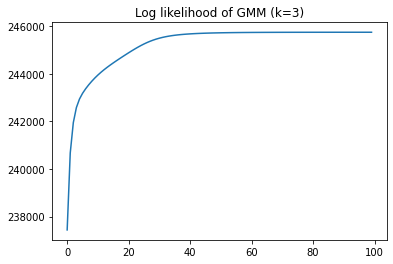

======= K = 3 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 137 | 125 |  87 |
|  1  |  80 |  67 |  58 |
|  2  | 128 | 131 | 124 |
+-----+-----+-----+-----+



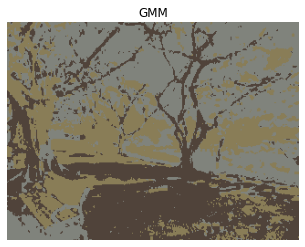

======= K = 5 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    |  84 |  70 |  69 |
|    1    | 147 | 151 | 137 |
|    2    |  91 |  66 |  44 |
|    3    |  85 |  66 |  59 |
|    4    |  53 |  48 |  18 |
+---------+-----+-----+-----+



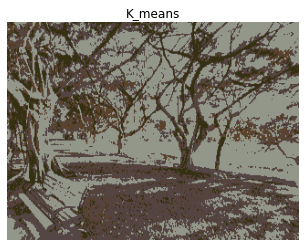

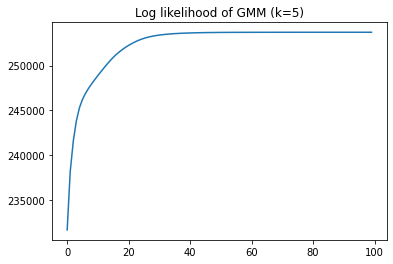

======= K = 5 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 116 | 101 |  78 |
|  1  |  77 |  64 |  57 |
|  2  | 223 | 223 | 221 |
|  3  | 141 | 150 | 110 |
|  4  | 128 | 132 | 131 |
+-----+-----+-----+-----+



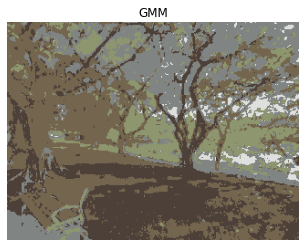

======= K = 7 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    |  74 |  73 |  79 |
|    1    | 104 | 112 |  63 |
|    2    | 124 | 129 | 123 |
|    3    | 108 |  95 |  76 |
|    4    |  61 |  44 |  28 |
|    5    | 127 | 134 |  93 |
|    6    |  56 |  51 |  19 |
+---------+-----+-----+-----+



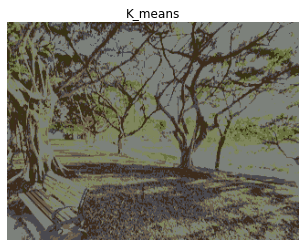

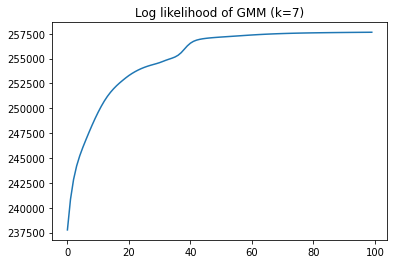

======= K = 7 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  |  77 |  64 |  57 |
|  1  | 117 | 105 |  95 |
|  2  | 125 | 108 |  88 |
|  3  | 129 | 133 |  81 |
|  4  | 158 | 166 | 152 |
|  5  | 156 | 161 | 163 |
|  6  |  74 |  67 |  44 |
+-----+-----+-----+-----+



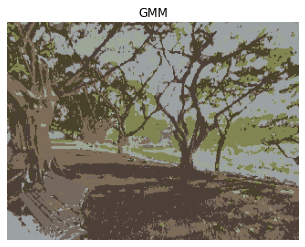

======= K = 10 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    |  95 | 104 | 103 |
|    1    | 101 | 100 |  46 |
|    2    | 119 |  99 |  90 |
|    3    | 161 | 135 | 120 |
|    4    |  63 |  69 |  23 |
|    5    | 176 | 153 | 121 |
|    6    | 154 | 159 |  69 |
|    7    | 117 |  99 |  77 |
|    8    |  81 |  74 |  66 |
|    9    | 143 | 152 |  97 |
+---------+-----+-----+-----+



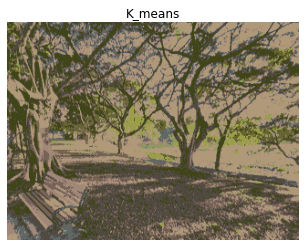

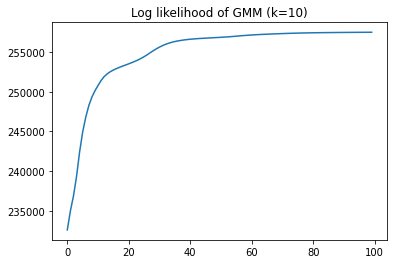

======= K = 10 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 109 | 113 | 115 |
|  1  |  77 |  64 |  57 |
|  2  | 138 | 118 | 109 |
|  3  | 140 | 117 |  96 |
|  4  |  94 |  89 |  53 |
|  5  | 146 | 151 |  98 |
|  6  | 116 |  90 |  71 |
|  7  | 176 | 185 | 188 |
|  8  | 143 | 133 | 108 |
|  9  |  74 |  69 |  54 |
+-----+-----+-----+-----+



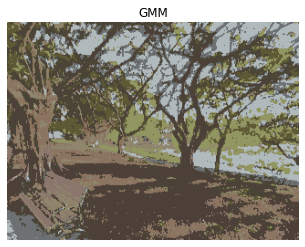

In [158]:
import numpy as np
from PIL import Image
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import prettytable as pt

def k_means_minimize(k,img):
  #initial
  K = k
  max_iteration = 300
  eye = np.eye(K)
  mu = img[np.random.choice(len(img), K, replace=False)]
  rnk = np.ones([len(img),K])
  #minimize
  for it in range(max_iteration):
    dists = np.sum((img[:, None] - mu)**2, axis=2) 
    rnk = eye[np.argmin(dists, axis=1)] 
    if np.array_equal(rnk,rnk): 
      break
    else: 
      rnk = rnk
    mu = np.sum(rnk[:, :, None] * img[:, None], axis=0) / np.sum(rnk, axis=0)[:, None]
  
  print_RGB("K_means",K,mu)
  Kmeans_image(mu,rnk)

def Gaussian_mixture_model(k,img): #K_means and EM
  #initial
  K = k
  max_iteration = 100
  likelihood_records = []
  #------------- rnk mu from K_means ------------
  eye = np.eye(K)
  mu_kmeans = img[np.random.choice(len(img), K, replace=False)]
  rnk = np.ones([len(img),K])
  for it in range(300):
    dists = np.sum((img[:, None] - mu_kmeans)**2, axis=2) 
    rnk = eye[np.argmin(dists, axis=1)] 
    if np.array_equal(rnk,rnk): 
      break
    else: 
      rnk = rnk
    mu_kmeans = np.sum(rnk[:, :, None] * img[:, None], axis=0) / np.sum(rnk, axis=0)[:, None]
  #---------------------------------------------------
  pi = np.sum(rnk, axis=0) / len(rnk)
  cov = np.array([ np.cov(img[np.where(rnk[:, k] == 1)[0]].T) for k in range(K) ]) # K*RGB*RGB
  gaussians = np.array([ multivariate_normal.pdf(img, mean=mu_kmeans[k], cov=cov[k])*pi[k] for k in range(K) ])
  #------------- EM ALG ------------
  for it in range(100):
    # E_steps
    gamma = (gaussians / np.sum(gaussians, axis=0)).T
    # M_steps
    Nk = np.sum(gamma, axis=0) 
    mu_gmm = np.sum(gamma[:, :, None]*img[:, None], axis=0) / Nk[:, None]
    for k in range(K):
      # update cov with minivalue to prevent LinAlgError
      cov[k] = (gamma[:, k, None]*(img - mu_gmm[k])).T.dot(img - mu_gmm[k]) / Nk[k] + 1e-7 * np.eye(depth)
    pi = Nk / len(img)

    #evaulate
    for k in range(K):
      try:
        gaussians[k] = multivariate_normal.pdf(img, mean=mu_gmm[k], cov=cov[k])*pi[k] 
      except np.linalg.linalg.LinAlgError:
        print('singular error at iteration %d' % it)
        mu[k] = np.random.rand(depth)
        temp = np.random.rand(depth, depth)
        cov[k] = temp.dot(temp.T)
        gaussians[k] = multivariate_normal.pdf(img, mean=mu_gmm[k], cov=cov[k])*pi[k]
    likelihood = np.sum(np.log(np.sum(gaussians, axis=0)))
    likelihood_records.append(likelihood)

  #plot
  plt.title('Log likelihood of GMM (k=%d)' % K)
  plt.plot([i for i in range(100)], likelihood_records)
  #plt.savefig('/content/gdrive/MyDrive/Colab/MLhw3/log_likelihood_'+str(K)+'.png')
  plt.show()

  print_RGB("GMM",K,mu_gmm)

  #generate GMM image
  GMM_image(k=K,mu=mu_gmm,gaussians=gaussians)

def print_RGB(name,K,mu):
  tb = pt.PrettyTable()
  tb.add_column(name, [k for k in range(K)])
  tb.add_column('R', [r for r in (mu[:, 0]*255).astype(int)])
  tb.add_column('G', [g for g in (mu[:, 1]*255).astype(int)])
  tb.add_column('B', [b for b in (mu[:, 2]*255).astype(int)])
  print("======= K = %d (%s) =======" % (k, name))
  print(tb)
  print()

def Kmeans_image(mu,rnk):
  new_data = (mu[np.where(rnk == 1)[1]] * 255).astype(int)
      
  disp = Image.fromarray(new_data.reshape(height, width, depth).astype('uint8'))
  #disp.show(title="Kmeans")
  #disp.save('/content/gdrive/MyDrive/Colab/MLhw3/'+"Kmeans"+str(k)+'.png')
  plt.imshow(disp)
  plt.axis('off')
  plt.title('K_means')
  plt.show()

def GMM_image(k,mu,gaussians):
  new_data = (mu[np.argmax(gaussians, axis=0)]*255).astype(int)
      
  disp = Image.fromarray(new_data.reshape(height, width, depth).astype('uint8'))
  #disp.show(title="GMM")
  #disp.save('/content/gdrive/MyDrive/Colab/MLhw3/'+"GMM"+str(k)+'.png')
  plt.imshow(disp)
  plt.axis('off')
  plt.title('GMM')
  plt.show()
  

img = Image.open('/content/gdrive/MyDrive/Colab/dataset/imghw3.jpg')
img.load()
photo = np.asarray(img, dtype='float')/255
height, width, depth = photo.shape
photo = np.reshape(photo, (-1, depth))

K_lists = [3, 5, 7, 10]

for k in K_lists:
  k_means_minimize(k,photo)
  Gaussian_mixture_model(k,photo)